In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

C:\Users\dell\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df = pd.read_csv('car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
df.shape

(301, 9)

In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Data Insights:
1. There is no missing values in the dataset.
2. Correct datatypes aligned to each of the features.
3. Selling price is the dependent variable. Rest other features are independent variables.


In [6]:
df['Car_Name'].nunique()

98

Since Car_Name contains 98 unique categories, and this number of categories is very high compared to the number of dataset samples, it is better to drop it:

In [7]:
df.drop('Car_Name', axis=1, inplace=True)

In [8]:
df.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Feature Transformation

Here we will perform below operations:
1. Handling Missing Values
2. Handling Categorical Values
3. Handling Outliers
4. Feature Scaling

In [9]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


####  Lets first Handle Outliers

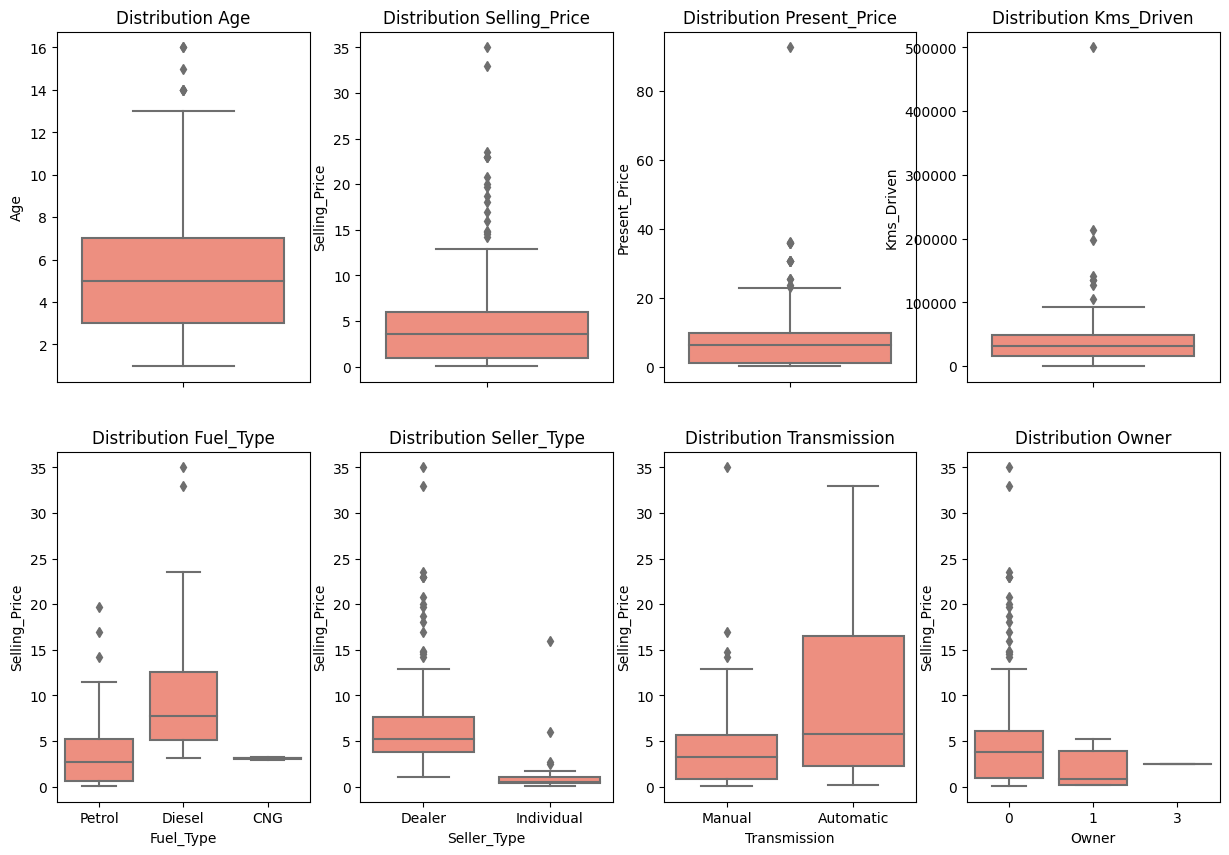

In [10]:
cols = df.columns.to_list()

# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 4, figsize=(15,10))

# Original Distributions
for i, col in enumerate(cols):
    if i <=3:
        sns.boxplot(data=df,y=df[col],ax=ax[0,i], color='#ff826e').set_title(f'Distribution {col}')
    else:
        sns.boxplot(data=df,x=df[col],y=df['Selling_Price'],ax=ax[1,i-4], color='#ff826e').set_title(f'Distribution {col}')
    

Above analysis shows that there are outliers in all the continuos variable. We will identify outliers with the help of IQR.

In [11]:
outliers_indexes = []
target = 'Selling_Price'

#For object features first we will fiter unique category in that column
#and then find q3 & q1 in respect to selling price column.
for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
#For continuos column we will find out q3 & q1 in respect to that column itself        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


It is not acceptable to drop an observation just because it is an outlier. They can be legitimate observations and it’s important to investigate the nature of the outlier before deciding whether to drop it or not. We are allowed to delete outliers in two cases:

Outlier is due to incorrectly entered or measured data

Outlier creates a significant association

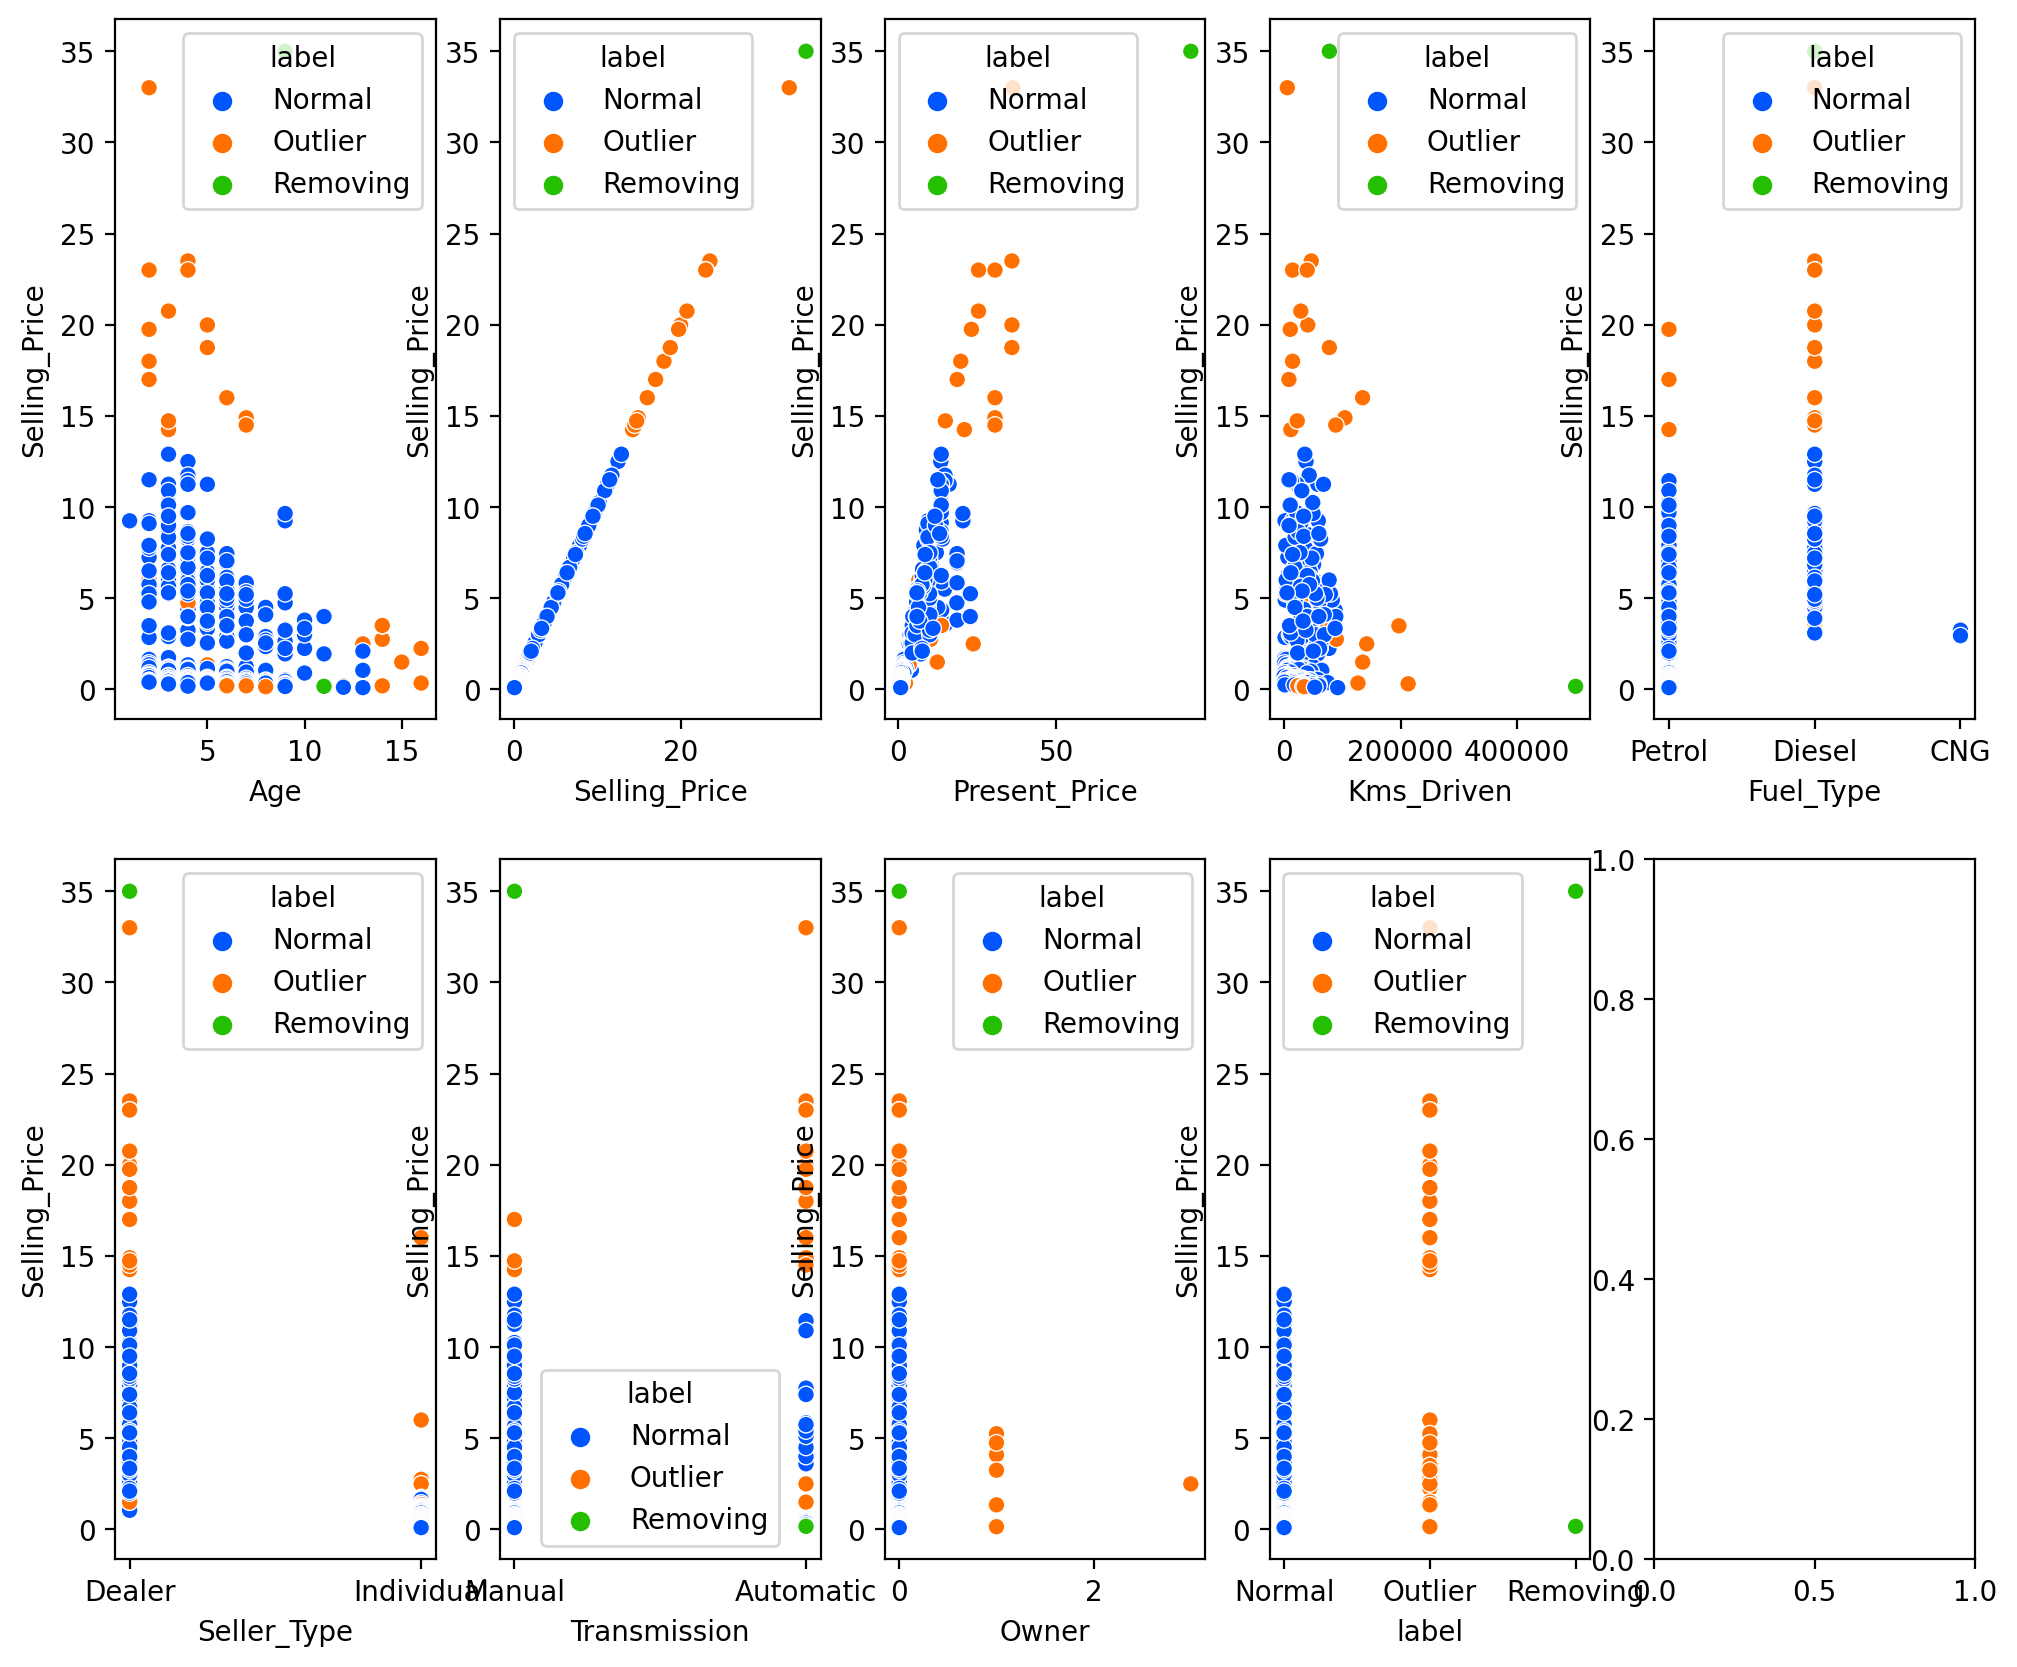

In [12]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'
target = 'Selling_Price'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=2 ,ncols=5, figsize=(12,10), dpi=200)

for i, col in enumerate(df1.columns.to_list()):
    if i <=4:
        sns.scatterplot(data=df1,x=df1[col],y=df['Selling_Price'],ax=ax[0,i],hue=df1['label'])
    else:
        sns.scatterplot(data=df1,x=df1[col],y=df['Selling_Price'],ax=ax[1,i-5],hue=df1['label'])


In [13]:
removing_indexes #We will drop these 2 indices

[86, 196]

In [14]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [15]:
df.duplicated().sum()

2

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.duplicated().sum()

0

In [18]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


## EDA

#### Categorical Univariate Analysis

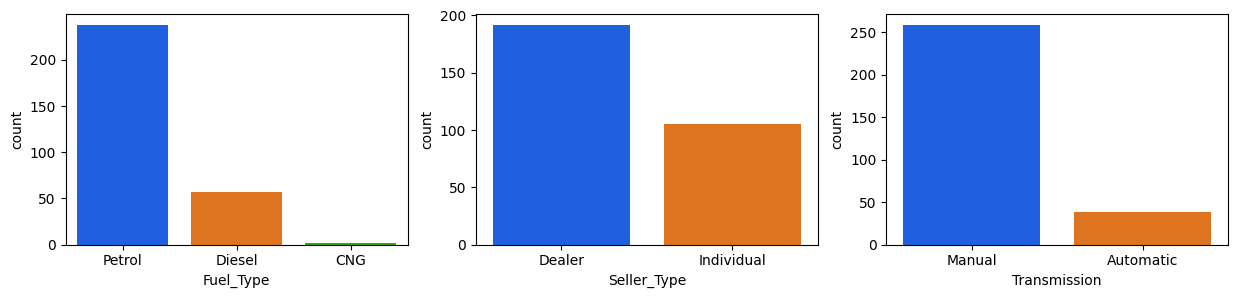

In [19]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']
fig, ax = plt.subplots(nrows=1 ,ncols=3, figsize=(15,3))


for i, col in enumerate(CatCols):
    sns.countplot(data=df1,x=col,ax=ax[i])


Conclusion:

There are 3 Fuel_Type categories. Petrol has the highest frequency and CNG has the least frequency.

There are 2 Seller_Type categories. Dealer has the highest frequency and Individual has the least frequency.

There are 2 Transmission categories. Manual has the highest frequency and Automatic has the least frequency.

#### Numerical Univariate Analysis

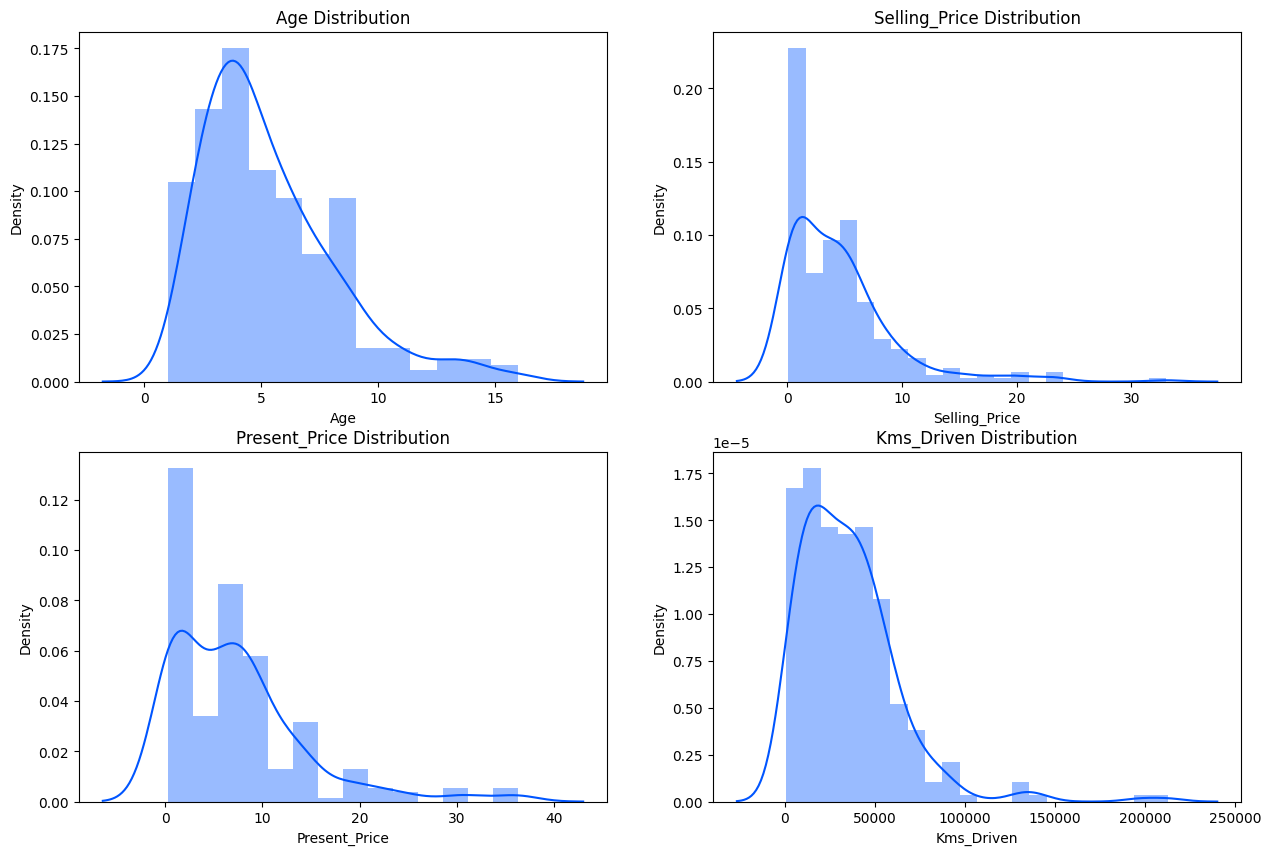

In [20]:
NumCols = ['Age', 'Selling_Price', 'Present_Price','Kms_Driven']
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(15,10))

import warnings
warnings.filterwarnings('ignore')
for i, col in enumerate(NumCols):
    if i <=1:
        sns.distplot(a=df1[col],hist=True,ax=ax[0,i],kde=True,label='F').set_title(f'{col} Distribution')
    else:
        sns.distplot(a=df1[col],hist=True,ax=ax[1,i-2],kde=True).set_title(f'{col} Distribution')


All Numerical variables are right skewed!

#### Bivariate Analysis - Selling Price with Numerical Features

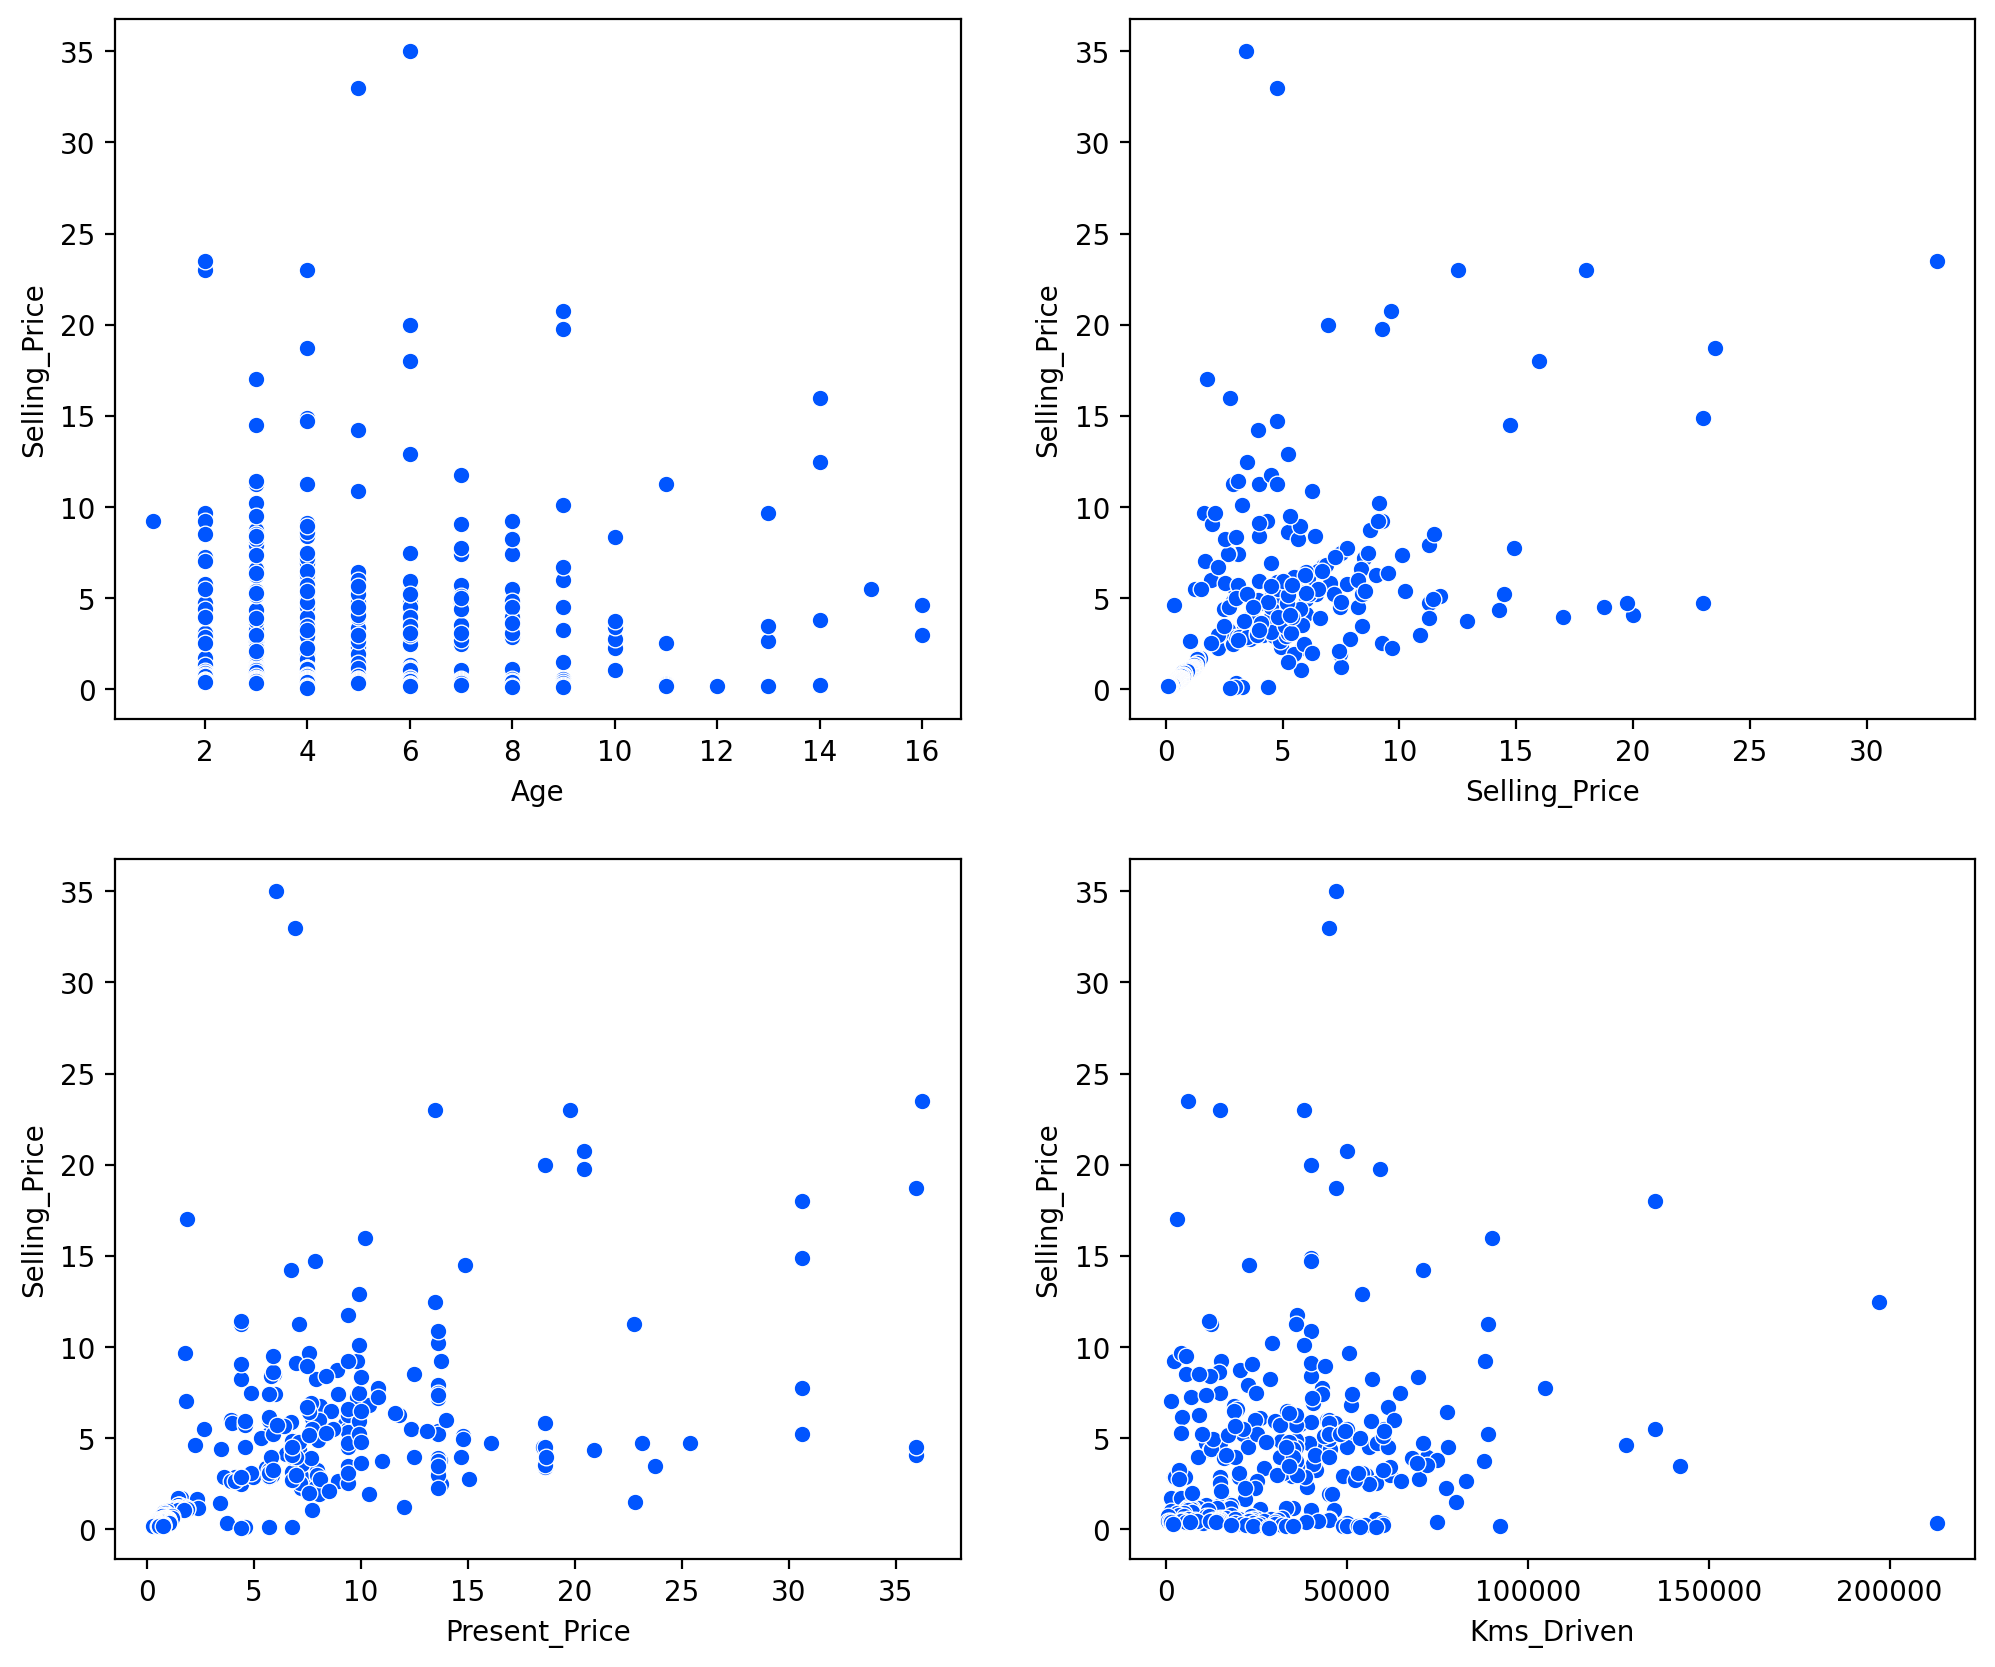

In [21]:
target = 'Selling_Price'
NumCols = ['Age', 'Selling_Price', 'Present_Price','Kms_Driven']
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(12,10), dpi=200)

for i, col in enumerate(NumCols):
    if i <=1:
        sns.scatterplot(data=df1,x=df1[col],y=df['Selling_Price'],ax=ax[0,i])
    else:
        sns.scatterplot(data=df1,x=df1[col],y=df['Selling_Price'],ax=ax[1,i-2])


Conclusion:
As Present_Price increases, Selling_Price increases as well. So Selling_Price is directly proportional to Present_Price.

As the car's Kms_Driven increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Kms_Driven.

As the car ages, its Selling_Price decreases. So Selling_Price is inversely proportional to the Age of the car.

As the number of previous car owners increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Owner.

### Handling Categorical Values

In [22]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,0,1,0,1
1,6,4.75,9.54,43000,0,1,0,0,1
2,2,7.25,9.85,6900,0,0,1,0,1
3,8,2.85,4.15,5200,0,0,1,0,1
4,5,4.60,6.87,42450,0,1,0,0,1


### Correlation Analysis

<AxesSubplot:>

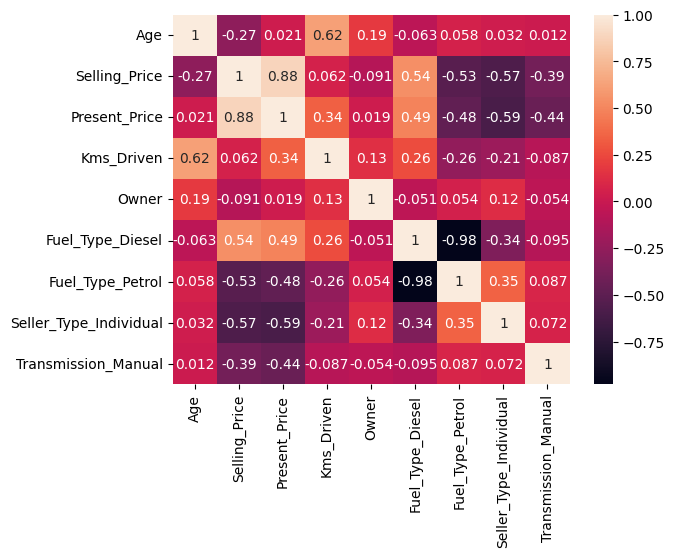

In [23]:
sns.heatmap(df1.corr(),annot=True)

The target variable "Selling Price" is highly correlated with Present_Price & Seller_Type & Fuel_Type.

Some independent variables like Fuel_Type_Petrol and Fuel_Type_Disel are highly correlated, which is called Multicollinearity.

## Model Building

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
X = df1.drop('Selling_Price',axis=1)
y = df1['Selling_Price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=0)

In [26]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [27]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred))

0.8807988852619915


In [28]:
print(lr.intercept_)
print(lr.coef_)

4.336570048309179
[-0.87191225  3.68355654 -0.56472082 -0.24050836  0.80657613  0.20795908
 -0.39228087 -0.08533517]


In [29]:
#Model Evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
def model_evaluation(model,X_test,y_test,model_name):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score],
                        index=['MAE', 'MSE', 'RMSE' ,'R2-Score'],
                        columns=[model_name])

In [30]:
result = model_evaluation(lr,X_test_scaled,y_test,'Lineare Regression')
result

,Lineare Regression
MAE,1.014296
MSE,2.828876
RMSE,1.681926
R2-Score,0.880799


In [31]:
lr.coef_

array([-0.87191225,  3.68355654, -0.56472082, -0.24050836,  0.80657613,
        0.20795908, -0.39228087, -0.08533517])

In [33]:
#Model Evaluation using Cross Validation
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.129362,0.199263
MSE,3.045037,1.105924
RMSE,1.715227,0.320987
R2-Score,0.841662,0.040340


The linear regression model obtained R2-score of %85.57 using 6-fold cross-validation.

Pipeline is a great way to prevent data leakage as it ensures that the appropriate method is performed on the correct data subset. This is ideal for using in cross-validation since it ensures that only the training folds are used when performing fit and the test set (validation set) is used only for calculating the accuracy score in each iteration of cross-validation.

### Assumptions in Linear Regression

1. Lineare Relationship -  Between Independent & Dependent feature.

2. No Multicollinearity - There should be no relation between Independent features. - Use a heatmap with correlation & VIF. Thumb rule is if VIF is greater than 10, then it means there is high multicollinearity.

3. Residuals should be normally distributed - Residuals (Actual-Predicted) should be normally distributed. - Check with histogram plot or QQ Plot.

4. Homoscedascity - Residuals should be uniformly scattered

5. No Autocorrelation of Residuals -  After plotting resisduals, there should be no pattern. This can be checked by Durbin Watson Test

<AxesSubplot:xlabel='Predicted', ylabel='Residuals'>

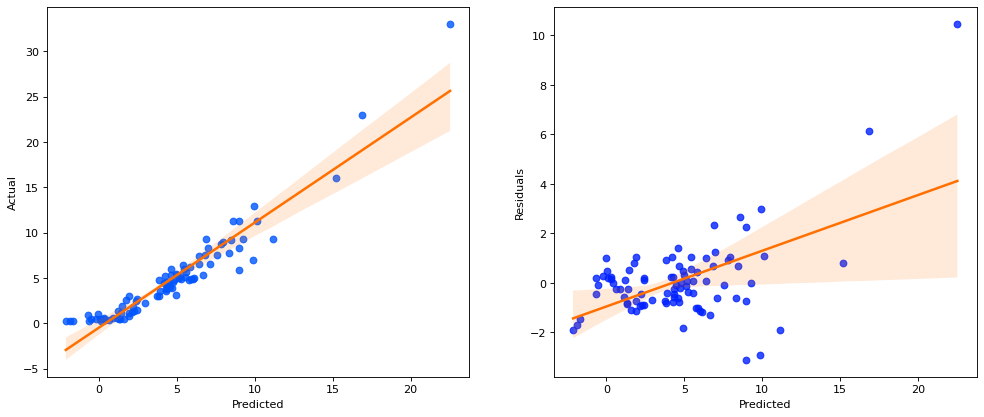

In [80]:
def residuals(model,X_test,y_test):
    y_pred = model.predict(X_test)
    result = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
    result['Residuals'] = abs(result['Actual']) - abs(result['Predicted'])
    return result

result_df = residuals(lr,X_test_scaled,y_test)

fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
sns.regplot(data=result_df,x='Predicted',y='Actual',ax=ax[0],color='#0055ff', line_kws={'color':'#ff7000'})
sns.regplot(data=result_df,x='Predicted',y='Residuals',ax=ax[1],color='#0020ff', line_kws={'color':'#ff7000'})

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []

for i in range(X_train.shape[1]):
    vif.append(variance_inflation_factor(X_train,i))
    
vif

[8.088020676251288,
 5.100503473741627,
 4.959240831592264,
 1.122496651213055,
 5.227744310074222,
 16.58686422934604,
 2.968270196773112,
 8.984719668353742]

In [89]:
def autocorrelation_assumption(model, X_test, y_test):
    '''
    It assumes that there is no autocorrelation in the residuals. If there is autocorrelation, then 
    there is a pattern that is not explained because the current value is dependent on the previous value.
    '''
    df_results = residuals(model, X_test, y_test)

    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', round(durbinWatson,3))
    
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation. Assumption not satisfied.', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation. Assumption not satisfied.', '\n')
    else:
        print('Little to no autocorrelation. Assumption satisfied.', '\n')

autocorrelation_assumption(lr, X_test_scaled, y_test)

Durbin-Watson: 1.826
Little to no autocorrelation. Assumption satisfied. 



In [94]:
 #This is not good model as there are few negative values predicted through model!
np.where(y_pred<0)

(array([ 8, 33, 38, 41, 43, 66, 78, 89], dtype=int64),)

In the following:

1. To satisfy the multicollinearity assumption, we remove the Fuel_Type_Petrol feature.

2. Then, according to the pattern in the plot of the residuals vs. predicted values, we will use box-cox transformation on the entire dataset.

3. By applying polynomial regression, we will try to improve the satisfaction of homoscedasticity and normality of residuals.

4. Finally, we will use regularization to reduce the probability of the model to be overfit.

In [96]:
df1.to_csv('cleaned.csv')

In [98]:
df1.drop(columns=['Fuel_Type_Petrol'],inplace=True)

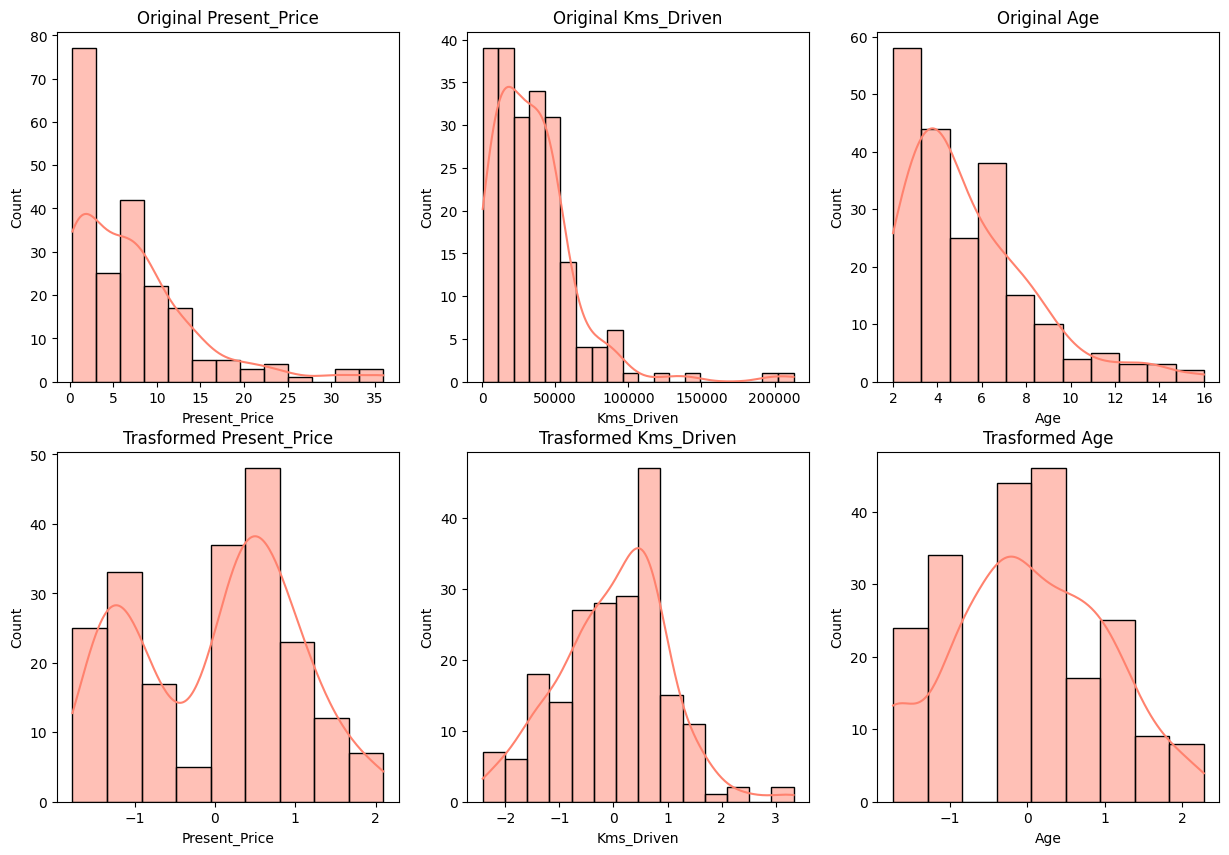

In [113]:
# Applying Box-Cox Transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')

X_train_transformed = pt.fit_transform(X_train+0.000001)
X_test_transformed = pt.transform(X_test+0.000001)

columns = X_train.columns.tolist()
X_Transformed = pd.DataFrame(data = X_train_transformed,columns=columns)

columns = ['Present_Price', 'Kms_Driven', 'Age']

# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 3, figsize=(15,10))

# Original Distributions
for i, col in enumerate(columns):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')
    
# Transformed Distributions
for i, col in enumerate(columns):
    sns.histplot(X_Transformed[col], kde=True, ax=ax[1,i], color='#ff826e').set_title(f'Trasformed {col}')   
    

Above analysis shows that data is normally distributed now

In [116]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_Transformed)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head(5)

,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,...,Fuel_Type_Diesel^2,Fuel_Type_Diesel Fuel_Type_Petrol,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Fuel_Type_Petrol^2,Fuel_Type_Petrol Seller_Type_Individual,Fuel_Type_Petrol Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,-0.306676,-1.467053,-1.239402,-0.187083,-0.458831,0.474186,1.286019,0.395505,0.094050,0.449910,...,0.210526,-0.217571,-0.590066,-0.181470,0.224852,0.609812,0.187543,1.653846,0.508628,0.156425
1,0.133566,-1.499993,-0.377452,-0.187083,-0.458831,0.474186,1.286019,-2.528410,0.017840,-0.200348,...,0.210526,-0.217571,-0.590066,1.160114,0.224852,0.609812,-1.198936,1.653846,-3.251585,6.392857
2,1.442313,1.136018,1.242063,-0.187083,-0.458831,0.474186,-0.777593,-2.528410,2.080268,1.638493,...,0.210526,-0.217571,0.356784,1.160114,0.224852,-0.368724,-1.198936,0.604651,1.966074,6.392857
3,-0.888379,-1.185902,-0.600866,-0.187083,-0.458831,0.474186,1.286019,0.395505,0.789218,1.053531,...,0.210526,-0.217571,-0.590066,-0.181470,0.224852,0.609812,0.187543,1.653846,0.508628,0.156425
4,1.248963,0.520639,0.502796,-0.187083,-0.458831,0.474186,-0.777593,0.395505,1.559908,0.650259,...,0.210526,-0.217571,0.356784,-0.181470,0.224852,-0.368724,0.187543,0.604651,-0.307542,0.156425
